## Use to statistically analyze the results generated from GPT.
### First load the libaray and read data into dataframe

python=3.12.9

conda activate AI_property

conda install -c conda-forge scikit-learn matplotlib seaborn

conda install -c conda-forge xlsxwriter


In [29]:
# import the necessary packages
import os
import numpy as np
import pandas as pd
import boto3
import time
import sys
from openai import OpenAI
import read_data
import GPT_model
import matplotlib.pyplot as plt

cwd = os.getcwd()
print(cwd)

'''
    The default sample file has 1000 samples.
    Named data_all_n1000.xlsx
'''
n = 1000
excel_path = f'./results/data_all_n{n}_old1.xlsx'
df_merged = pd.read_excel(excel_path)
if n == 2000:
    df_merged = df_merged[0:1000]
print(f'The length of dataset is {len(df_merged)}')
df_merged.head()


/home/sagemaker-user/HO_AI_Property_Attribute_2025
The length of dataset is 1000


,address,city,state,zip5,zip4,unit_number,county,fault_code,status_code,delivery_bc,qpid,rundt,Number_of_Baths,Number_of_Bedrooms,predicted_bathroom,predicted_bedroom,tokens_used,time_seconds
0,340 HOBART AVE,ABSECON,NJ,8201,1127,NaN,ATLANTIC,NaN,S80000,82011127404,84770770,202410,2.0,3,1.0,3,88,1.44
1,244 PENNSYLVANIA AVE,ABSECON,NJ,8201,1219,NaN,ATLANTIC,NaN,S80000,82011219448,84770874,202410,2.0,3,2.0,3,90,0.66
2,319 E WYOMING AVE,ABSECON,NJ,8201,1711,NaN,ATLANTIC,NaN,S80000,82011711199,84770989,202410,4.0,4,2.0,3,89,1.59
3,312 SPRUCE ST,ABSECON,NJ,8201,1726,NaN,ATLANTIC,NaN,S80000,82011726120,84771105,202410,2.0,4,1.0,3,86,0.36
4,905 TRAYMORE PKWY,ABSECON,NJ,8201,1513,NaN,ATLANTIC,NaN,S80000,82011513054,84771453,202410,1.1,2,2.0,3,88,0.64


### Calculate the difference between predicted and actual number

There are 318 bathroom difference are within 0.
There are 435 bedroom difference are within 0.
There are 814 bathroom difference are within 1.
There are 840 bedroom difference are within 1.


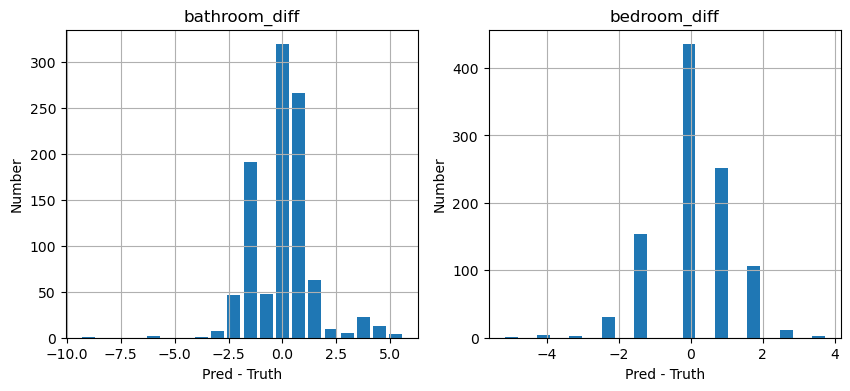

In [41]:
# First calculate the difference between the prediction and samples
# Ensure numeric types for accurate subtraction
df_merged['predicted_bathroom'] = df_merged['predicted_bathroom'].astype(float)
df_merged['Number_of_Baths'] = df_merged['Number_of_Baths'].astype(float)
df_merged['predicted_bedroom'] = df_merged['predicted_bedroom'].astype(int)
df_merged['Number_of_Bedrooms'] = df_merged['Number_of_Bedrooms'].astype(int)

# Calculate prediction errors (signed and absolute)
df_merged['bathroom_diff'] = df_merged['predicted_bathroom'] - df_merged['Number_of_Baths'] 
df_merged['bedroom_diff'] = df_merged['predicted_bedroom'] - df_merged['Number_of_Bedrooms'] 
df_merged['bathroom_abs_diff'] = df_merged['bathroom_diff'].abs()
df_merged['bedroom_abs_diff'] = df_merged['bedroom_diff'].abs()

# Plot histograms of signed prediction errors
fig, axes= plt.subplots(1, 2,  figsize=(10, 4))

var = ['bathroom_diff', 'bedroom_diff']
for i in range(2):
    ax = axes[i]
    ax.hist(df_merged[var[i]], bins=20, align='left', rwidth=0.8)
    ax.set_title(var[i])
    ax.set_xlabel('Pred - Truth')
    ax.set_ylabel('Number')
    ax.grid(True)

# Print accuracy summary at different tolerance levels
print(f'There are {sum(df_merged['bathroom_diff']==0)} bathroom difference are within 0.')
print(f'There are {sum(df_merged['bedroom_abs_diff']<=0)} bedroom difference are within 0.')

print(f'There are {sum(df_merged['bathroom_abs_diff']<=1)} bathroom difference are within 1.')
print(f'There are {sum(df_merged['bedroom_abs_diff']<=1)} bedroom difference are within 1.')

plt.show()


Export the results to Excel:\
1: Import the Excel writer\
2: Compute histogram counts for prediction differences (bins: -4 to +4)\
3: Create a DataFrame for Excel export\
4: Export histogram data to Excel and add editable charts\
5: Create a column chart for bathroom prediction differences\
6: Create a column chart for bedroom prediction differences\
7: Insert charts into the worksheet


In [47]:
# Next is to plot them in the Excel-based plots, which is editable inside Excel.
import xlsxwriter

# === Compute histogram bin counts ===
bin_range = range(-4, 5)  # From -5 to +5
bathroom_counts = df_merged['bathroom_diff'].value_counts().reindex(bin_range, fill_value=0)
bedroom_counts = df_merged['bedroom_diff'].value_counts().reindex(bin_range, fill_value=0)

# === Create DataFrame for Excel export ===
hist_df = pd.DataFrame({
    'Bin': list(bin_range),
    'Bathroom Diff Count': bathroom_counts.values,
    'Bedroom Diff Count': bedroom_counts.values
})

# === Export to Excel with charts ===
excel_path = './histogram/pred-truth.xlsx'
with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
    hist_df.to_excel(writer, sheet_name='Histograms', index=False)
    workbook  = writer.book
    worksheet = writer.sheets['Histograms']

    # Create bathroom_diff chart
    chart1 = workbook.add_chart({'type': 'column'})
    chart1.add_series({
        'name': 'Bathroom Diff',
        'categories': ['Histograms', 1, 0, len(bin_range), 0],  # Bin
        'values':     ['Histograms', 1, 1, len(bin_range), 1],  # Bathroom Count
    })
    chart1.set_title({'name': 'Bathroom Prediction Difference'})
    chart1.set_x_axis({
        'name': 'Predicted - Ground Truth',
        'name_font': {'size': 14},
        'num_font': {'size': 12}
    })
    chart1.set_y_axis({
        'name': 'Count',
        'name_font': {'size': 14},
        'num_font': {'size': 12}
    })

    # Create bedroom_diff chart
    chart2 = workbook.add_chart({'type': 'column'})
    chart2.add_series({
        'name': 'Bedroom Diff',
        'categories': ['Histograms', 1, 0, len(bin_range), 0],
        'values':     ['Histograms', 1, 2, len(bin_range), 2],
    })
    chart2.set_title({'name': 'Bedroom Prediction Difference'})
    chart2.set_x_axis({
        'name': 'Predicted - Ground Truth',
        'name_font': {'size': 14},
        'num_font': {'size': 12}
    })
    chart2.set_y_axis({
        'name': 'Count',
        'name_font': {'size': 14},
        'num_font': {'size': 12}
    })
    # Insert charts into worksheet
    worksheet.insert_chart('E2', chart1)
    worksheet.insert_chart('E20', chart2)

print(f'✅ Excel file with editable charts saved to: {excel_path}')


✅ Excel file with editable charts saved to: ./histogram/pred-truth.xlsx


In [31]:
# This part is to output some key information
# Generate the general difference for # of bathrooms and bedrooms
print('Bathroom max diff is at: ')
temp = np.argmax(df_merged['bathroom_abs_diff'])
print('The maximum bath diff is at index ', np.argmax(df_merged['bathroom_abs_diff']), 'the value is ', df_merged['bathroom_abs_diff'][temp])
print('The predicted and truth numbers are ', df_merged['predicted_bathroom'][temp], df_merged['Number_of_Baths'][temp] )

temp = np.argmax(df_merged['bedroom_abs_diff'])
print('The maximum bedroom diff is at index ', np.argmax(df_merged['bedroom_abs_diff']), 'the value is ', df_merged['bedroom_abs_diff'][temp])
print('The predicted and truth numbers are ', df_merged['predicted_bedroom'][temp], df_merged['Number_of_Bedrooms'][temp] )


print("🛏️ Bedroom Prediction Error:")
print(df_merged['bedroom_abs_diff'].describe())

print("\n🛁 Bathroom Prediction Error:")
print(df_merged['bathroom_abs_diff'].describe())

Bathroom max diff is at: 
The maximum bath diff is at index  145 the value is  9.0
The predicted and truth numbers are  2.0 11.0
The maximum bedroom diff is at index  170 the value is  5
The predicted and truth numbers are  3 8
🛏️ Bedroom Prediction Error:
count    1000.000000
mean        0.755000
std         0.802258
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: bedroom_abs_diff, dtype: float64

🛁 Bathroom Prediction Error:
count    999.000000
mean       0.943443
std        1.071836
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        9.000000
Name: bathroom_abs_diff, dtype: float64


### Confusion matrix style table
Rows: true bedroom/bathroom number \
Columns: predicted bedroom/bathroom number

Add a summary sheet \
Add “Difference Within ±1” Mask

In [32]:
# import the libary 
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Steps:\
1: Prepare a clean DataFrame with the key columns\
2: Calculate absolute differences and ±1 tolerance flags\
3: Generate summary tables (group by true value)\
4: Create high-level accuracy summary\
5: Export all results and summaries to Excel


In [33]:
# Confusion matrix


def generate_gpt_comparison_report(df_merged, output_excel_path='./gpt_comparison_report.xlsx'):
    """
    Generate a report comparing GPT predictions to ground truth with diffs, tolerance stats,
    and confusion matrices. Also export to Excel.
    """

    # the necessary info
    report = pd.DataFrame({
        'qpid': df_merged['qpid'],
        'true_bedrooms': df_merged['Number_of_Bedrooms'],
        'predicted_bedrooms': df_merged['predicted_bedroom'],
        'bedrooms_diff': df_merged['bedroom_diff'],
        'true_bathrooms': df_merged['Number_of_Baths'].astype(float),
        'predicted_bathrooms': df_merged['predicted_bathroom'].astype(float),
        'bathrooms_diff': df_merged['bathroom_diff'].astype(float),
        'tokens_used': df_merged['tokens_used'],
        'time_seconds': df_merged['time_seconds']
    })

    # tolerence is within 1
    report['bedroom_abs_diff'] = report['bedrooms_diff'].abs()
    report['bathroom_abs_diff'] = report['bathrooms_diff'].abs()
    
    report['bedroom_within_1'] = report['bedrooms_diff'].abs() <= 1
    report['bathroom_within_1'] = report['bathrooms_diff'].abs() <= 1
    report['both_within_1'] = report['bedroom_within_1'] & report['bathroom_within_1']
    
    # the bathroom number is float
    compare_keywords = ['bathrooms', 'bedrooms']

    # generate the summary page
    # including the accuracy of bedroom, bathroom within 1
    # including the exact match number
    bed_summary = report.groupby('true_bedrooms').agg(
        count=('qpid', 'count'),
        exact_match=('bedroom_abs_diff', lambda x: (x == 0).sum()),
        within_1=('bedroom_abs_diff', lambda x: (x <= 1).sum())
    ).round(2).reset_index().rename(columns={'true_bedrooms': 'Number of bedrooms'})
    bed_summary.insert(0, 'type', 'bedroom')

    bath_summary = report.groupby('true_bathrooms').agg(
        count=('qpid', 'count'),
        exact_match=('bathroom_abs_diff', lambda x: (x == 0).sum()),
        within_1=('bathroom_abs_diff', lambda x: (x <= 1).sum())
    ).round(2).reset_index().rename(columns={'true_bathrooms': 'Number of bathrooms'})
    bath_summary.insert(0, 'type', 'bathroom')
    summary_all = pd.concat([bath_summary, bed_summary],  keys=compare_keywords)
    #summary_all = pd.concat([bath_summary, bed_summary], ignore_index=True, axis=1)


    # Accuracy_Summary table
    accuracy_summary = pd.DataFrame({
        'Metric': ['Bedroom ±1', 'Bathroom ±1', 'Both ±1'],
        'Accuracy (%)': [
            round(report['bathroom_within_1'].mean() * 100, 2),
            round(report['bedroom_within_1'].mean() * 100, 2),
            round(report['both_within_1'].mean() * 100, 2)
        ]
    })

    cm_output = []
    with pd.ExcelWriter(output_excel_path, engine='openpyxl') as writer:
        summary_all.to_excel(writer, sheet_name="Summary", index=False)
        accuracy_summary.to_excel(writer, sheet_name="Summary2", index=False)

        for keyword in compare_keywords:
            row = report['true_'+keyword]; column = report['predicted_'+keyword]
            cm = pd.crosstab(
                row, column,
                rownames=['True '+ keyword],
                colnames=['Predicted ' +keyword ],
                margins=True,
                margins_name='Total'
            )
            # Add the percentage for the total
            total_count = cm.loc['Total', 'Total']

            formatted = cm.copy().astype(str)
            for r in cm.index:
                for c in cm.columns:
                    val = cm.loc[r, c]
                    if r == 'Total' or c == 'Total':
                        pct = (val / total_count) * 100 if total_count > 0 else 0
                        formatted.loc[r, c] = f"{val}({pct:.1f}%)"
                    else:
                        formatted.loc[r, c] = str(val)
            formatted.to_excel(writer, sheet_name=keyword)
            cm_output.append(cm)


    print(f'Report and confusion matrices saved to: {output_excel_path}')

    return report, cm_output



In [34]:
# modify the width of the Excel cell to make it more clear
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter

output_path = './results/confusion_matrix.xlsx'
report, [bathroom_cm, bedroom_cm] = generate_gpt_comparison_report(
    df_merged, output_excel_path=output_path
)

wb = load_workbook(output_path)

for sheet_name in wb.sheetnames:
    if sheet_name == "Summary" or sheet_name == 'Summary2' :
        ws = wb[sheet_name]
 
    else:
        ws = wb[sheet_name]
        ws.insert_rows(1)

        ws['C1'] = 'Predited number'
        ws.insert_cols(1)
        ws['A4'] = 'Ground Truth'
    for col in ws.columns:
        max_len = 0
        col_letter = get_column_letter(col[0].column)
        for cell in col:
            try:
                val_len = len(str(cell.value))
                max_len = max(max_len, val_len)
            except:
                pass
        ws.column_dimensions[col_letter].width = max_len * 1.2

wb.save(output_path)
print('The Excel is successfully modified')

Report and confusion matrices saved to: ./results/confusion_matrix.xlsx
The Excel is successfully modified


### Visualize the confusion matrix
Hight the difference within 1

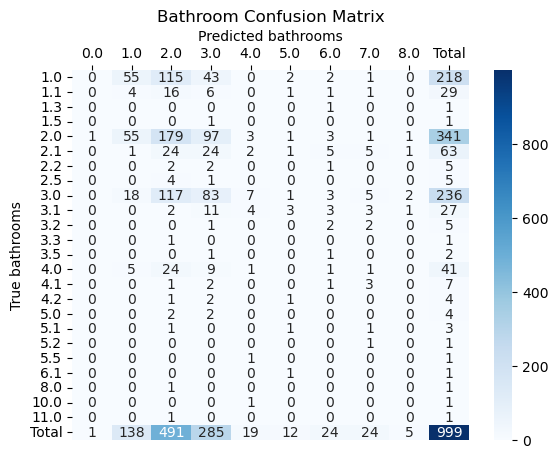

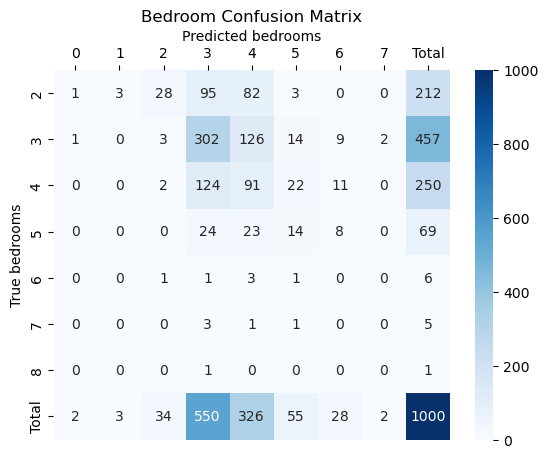

In [35]:
# First plot the original confusion matrix
'''
fig, axes = plt.subplots(2, 1, figsize=(8,20))

var = [bathroom_cm, bedroom_cm]
titles = [
    'Confusion matrix for number of bathrooms', 
    'Confusion matrix for number of bedrooms'
]
for i in range(2):
    ax = axes[i]
    sns.heatmap(
        var[i],
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=True,
        ax= ax
    )    
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    ax.tick_params(top=True, bottom=False)

    ax.set_title(titles[i])
    ax.set_xlabel('Predicted number')
    ax.set_ylabel('True number')
    # plt.tight_layout()

plt.show()
'''



ax = sns.heatmap(
    bathroom_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True
)
ax.xaxis.set_ticks_position('top')       
ax.xaxis.set_label_position('top')      
ax.tick_params(top=True, bottom=False) 
plt.title('Bathroom Confusion Matrix')
plt.show()

ax = sns.heatmap(
    bedroom_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True
)
ax.xaxis.set_ticks_position('top')       
ax.xaxis.set_label_position('top')      
plt.title('Bedroom Confusion Matrix')
plt.show()


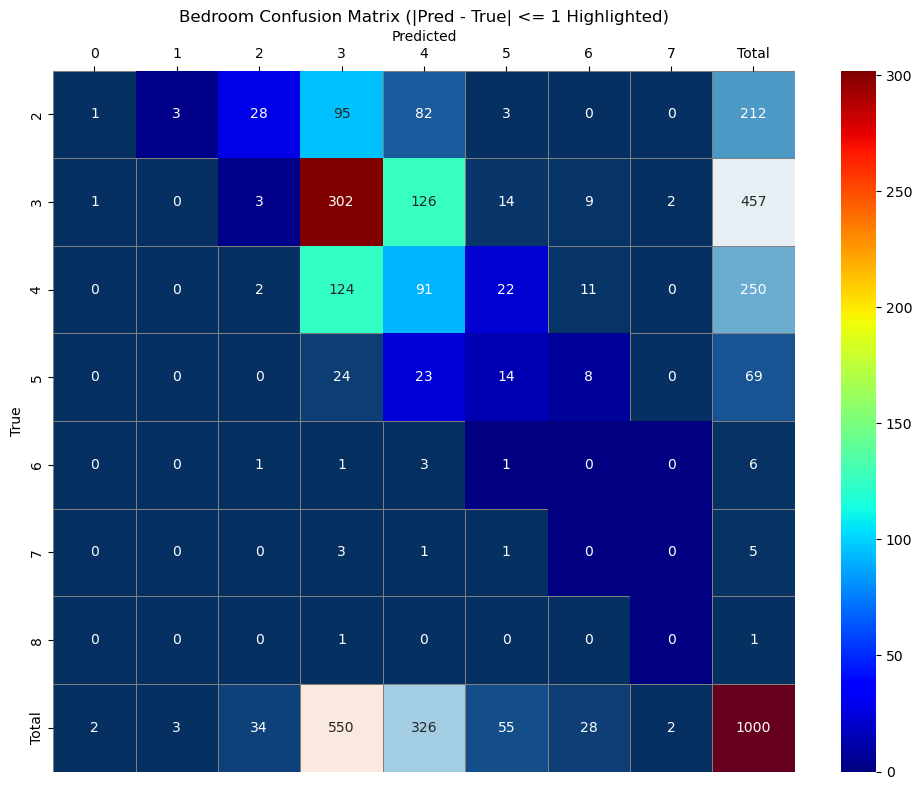

In [36]:
# hightlight the above figure the value with difference less than 1
bedroom_cm.astype('int')
# bedroom_cm.index = bedroom_cm.index.astype(int)
# bedroom_cm.columns = bedroom_cm.columns.astype(int)

true_labels = bedroom_cm.index[:-1].values
pred_labels = bedroom_cm.columns[:-1].values

# mask matrix, the True is not highlighted
mask = np.ones_like(bedroom_cm, dtype=bool)
for i, true_val in enumerate(true_labels):
    for j, pred_val in enumerate(pred_labels):
        if abs(true_val - pred_val) <= 1:  # difference less than 1: highlighted
            mask[i, j] = False

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    bedroom_cm,
    annot=True,
    fmt='d',
    cmap='RdBu_r',
    mask=~mask,  
    cbar=False,
    linewidths=0.5,
    linecolor='gray'
)
sns.heatmap(
    bedroom_cm,
    annot=True,
    fmt='d',
    cmap='jet',
    mask=mask,     
    ax=ax
)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.title('Bedroom Confusion Matrix (|Pred - True| <= 1 Highlighted)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


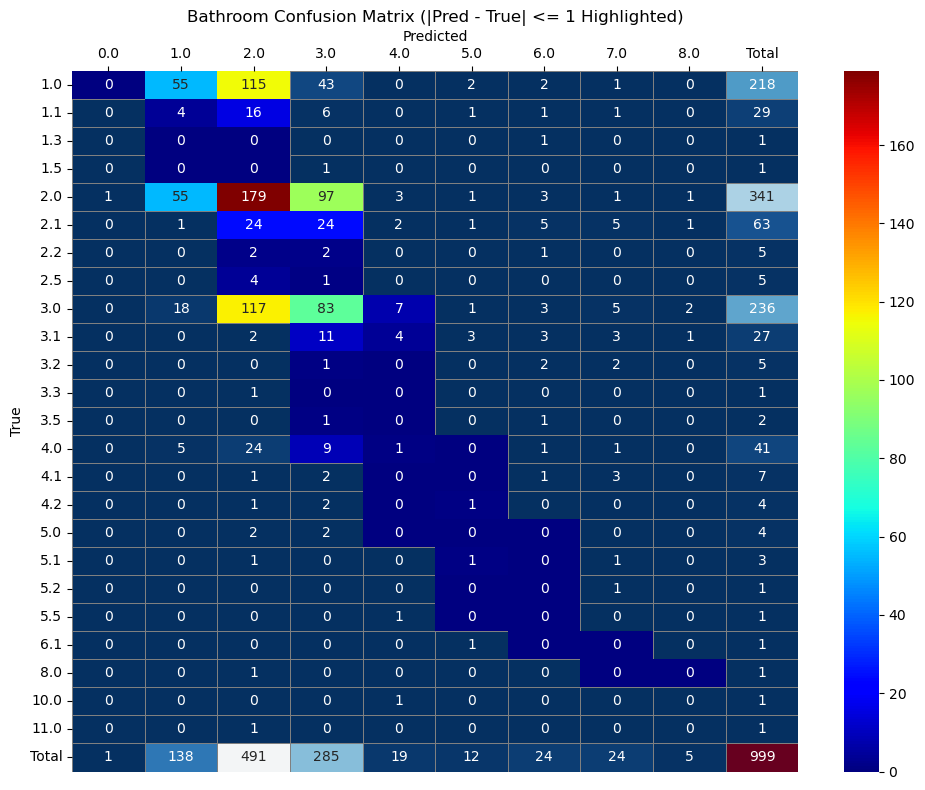

In [37]:
# hightlight the above figure the value with difference less than 1
bathroom_cm.astype('int')
# bathroom_cm.index = bathroom_cm.index.astype(int)
# bathroom_cm.columns = bathroom_cm.columns.astype(int)

true_labels = bathroom_cm.index[:-1].values
pred_labels = bathroom_cm.columns[:-1].values

# mask matrix, the True is not highlighted
mask = np.ones_like(bathroom_cm, dtype=bool)
for i, true_val in enumerate(true_labels):
    for j, pred_val in enumerate(pred_labels):
        if abs(true_val - pred_val) <= 1:  # difference less than 1: highlighted
            mask[i, j] = False

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    bathroom_cm,
    annot=True,
    fmt='d',
    cmap='RdBu_r',
    mask=~mask,  
    cbar=False,
    linewidths=0.5,
    linecolor='gray'
)
sns.heatmap(
    bathroom_cm,
    annot=True,
    fmt='d',
    cmap='jet',
    mask=mask,     
    ax=ax
)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.title('Bathroom Confusion Matrix (|Pred - True| <= 1 Highlighted)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()
